# Word embedding visualizations per region


This notebook computes visualizations based on UMAP projections of word embeddings.

Notes:
- The embeddings should be already computed to run this notebook
- If you want to avoid some country from visualizations, just remove it from the `VALIC_CC` list 



In [1]:
using Pkg
Pkg.activate("..")
# GQ was removed since it has too few intersecting tokens
# adds ALL 
VALID_CC = ["ALL", "AR", "BO", "CA", "CL", "CO", "CR", "DO", "EC", "ES", "FR", "GB", "GT", "HN", "MX", "NI", "PA", "PE", "PY", "SV", "US", "UY", "VE"]
using SimilaritySearch, SimSearchManifoldLearning, TextSearch, LinearAlgebra, HDF5, JSON, JLD2, CSV, DataFrames, Glob, StatsBase, Plots

  Activating project at `~/Research/regional-spanish-models`
┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1664
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1664


In [2]:
edir = "../data/SpanishLang/embeddings"
k = 33
common = nothing
#common = CSV.read("../data/SpanishLang/voc/ALL.tsv.gz", DataFrame, delim='\t')
#subset!(common, :n_regions => n -> n .>= 10)

In [3]:
function encode_model(knns, dists, vocab)
    #vocab = Symbol.(vocab)
    #  ivocab = Dict(token => i for (i, token) in enumerate(vocab))
    obj = Dict{UInt64,Float64}()
    for (i, (idcol, distcol)) in enumerate(zip(eachcol(knns), eachcol(dists)))
        for j in eachindex(idcol, distcol)
            w = (vocab[i], vocab[idcol[j]])
            s = hash(w)
            obj[s] = 0.5 + 1 / (1 + distcol[j])
        end
    end
 
    normalize!(obj)
end

encode_model (generic function with 1 method)

In [4]:
db = []

for cc in VALID_CC
    modelname = only(glob(joinpath(edir, "knns-common-tokens.cc=$cc*.h5")))
    @info modelname
    knns_, dists_, vocab_ = load(modelname, "knns", "dists", "vocab")
    push!(db, encode_model(knns_, dists_, vocab_))
end

length(db)

┌ Info: ../data/SpanishLang/embeddings/knns-common-tokens.cc=ALL-1.7m.k=33.h5
└ @ Main In[4]:5
┌ Info: ../data/SpanishLang/embeddings/knns-common-tokens.cc=AR.k=33.h5
└ @ Main In[4]:5
┌ Info: ../data/SpanishLang/embeddings/knns-common-tokens.cc=BO.k=33.h5
└ @ Main In[4]:5
┌ Info: ../data/SpanishLang/embeddings/knns-common-tokens.cc=CA.k=33.h5
└ @ Main In[4]:5
┌ Info: ../data/SpanishLang/embeddings/knns-common-tokens.cc=CL.k=33.h5
└ @ Main In[4]:5
┌ Info: ../data/SpanishLang/embeddings/knns-common-tokens.cc=CO.k=33.h5
└ @ Main In[4]:5
┌ Info: ../data/SpanishLang/embeddings/knns-common-tokens.cc=CR.k=33.h5
└ @ Main In[4]:5
┌ Info: ../data/SpanishLang/embeddings/knns-common-tokens.cc=DO.k=33.h5
└ @ Main In[4]:5
┌ Info: ../data/SpanishLang/embeddings/knns-common-tokens.cc=EC.k=33.h5
└ @ Main In[4]:5
┌ Info: ../data/SpanishLang/embeddings/knns-common-tokens.cc=ES.k=33.h5
└ @ Main In[4]:5
┌ Info: ../data/SpanishLang/embeddings/knns-common-tokens.cc=FR.k=33.h5
└ @ Main In[4]:5
┌ Info: ../data

23

In [5]:
dist = NormalizedCosineDistance()
n = length(VALID_CC)
A = Matrix{Float64}(undef, n, n)

for (i, cc) in enumerate(VALID_CC)
    u = db[i]
    A[i, i] = 0.0
    @time for j in i+1:n
        v = db[j]
        A[j, i] = A[i, j] = evaluate(dist, u, v)
    end
end

  4.356918 seconds (29.98 k allocations: 1.531 MiB, 0.66% compilation time)
  3.554703 seconds (43 allocations: 1.016 KiB)
  1.359134 seconds (41 allocations: 992 bytes)
  1.492296 seconds (39 allocations: 944 bytes)
  2.721092 seconds (37 allocations: 896 bytes)
  2.613228 seconds (35 allocations: 848 bytes)
  1.676489 seconds (33 allocations: 800 bytes)
  1.515869 seconds (31 allocations: 752 bytes)
  1.583688 seconds (29 allocations: 704 bytes)
  1.787404 seconds (27 allocations: 656 bytes)
  0.899696 seconds (25 allocations: 608 bytes)
  0.899835 seconds (23 allocations: 560 bytes)
  0.974653 seconds (21 allocations: 512 bytes)
  0.693446 seconds (19 allocations: 464 bytes)
  1.293334 seconds (17 allocations: 416 bytes)
  0.560360 seconds (15 allocations: 368 bytes)
  0.818805 seconds (13 allocations: 320 bytes)
  0.708276 seconds (11 allocations: 272 bytes)
  0.480784 seconds (9 allocations: 224 bytes)
  0.275990 seconds (7 allocations: 176 bytes)
  0.381864 seconds (5 allocations

In [6]:
function creatergb!(C)
    for i in (1, 2, 3)
        v = @view C[i, :]
        # s = 4 * std(v)
        min_, max_ = extrema(v)
        # v .= v ./ s .+ 0.5

        for j in eachindex(v)
            x = (v[j] - min_) / (max_ - min_)
            v[j] = clamp(x,  0.1, 0.9)
        end
    end

    [RGB(c...) for c in eachcol(C)]
end

creatergb! (generic function with 1 method)

## UMAP projections

The UMAP projection uses the affinity matrix computed above. The following cell contains the hyperparameters and code to compute it. Note that here $k$ is in fact $k-1$ since self-reference is not removed while computing the nn graph. For instance, when we give $k=4$ we will obtain a projection induced by the $3$nn graph.


It is worth to mention that UMAP projections will change since it is based on an stochastic procedure. You will find that it is quite stable locally inside clusters, but clusters tend to rotate.

┌ Info: ======= k=4 =====
└ @ Main In[7]:9


  0.038960 seconds (167.43 k allocations: 8.036 MiB, 98.42% compilation time)


*** computing graph
*** layout embedding SpectralLayout
*** fit ab / embedding


  0.000007 seconds (3 allocations: 976 bytes)


*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 0.113427605
- embedding init: 1.351014996
- embedding opt: 0.003769723

*** computing graph
*** layout embedding SpectralLayout
*** fit ab / embedding
*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 3.6854e-5
- embedding init: 0.000524065
- embedding opt: 0.008183183

┌ Info: (:r, :g, :b)
└ @ Main In[7]:33


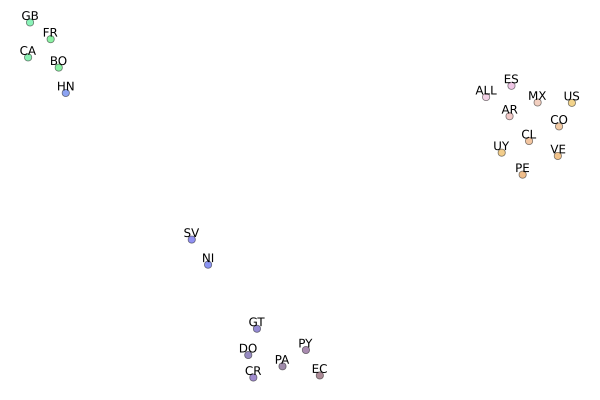

  0.000246 seconds (3 allocations: 1.297 KiB)
  0.000005 seconds (3 allocations: 1.297 KiB)


┌ Info: ======= k=6 =====
└ @ Main In[7]:9
*** computing graph
*** layout embedding SpectralLayout
*** fit ab / embedding
*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 6.2899e-5
- embedding init: 0.000456598
- embedding opt: 0.011742634

*** computing graph
*** layout embedding SpectralLayout
*** fit ab / embedding
*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 4.0167e-5
- embedding init: 0.000322615
- embedding opt: 0.003493264

┌ Info: (:r, :g, :b)
└ @ Main In[7]:33


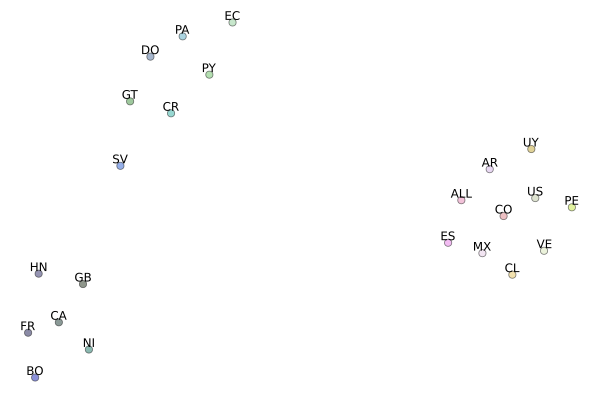

  0.000229 seconds (3 allocations: 1.672 KiB)
  0.000005 seconds (3 allocations: 1.672 KiB)


┌ Info: ======= k=8 =====
└ @ Main In[7]:9
*** computing graph
*** layout embedding SpectralLayout
*** fit ab / embedding
*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 3.9731e-5
- embedding init: 0.000352165
- embedding opt: 0.01459488

*** computing graph
*** layout embedding SpectralLayout
*** fit ab / embedding
*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 3.2372e-5
- embedding init: 0.000300612
- embedding opt: 0.003751913

┌ Info: (:r, :g, :b)
└ @ Main In[7]:33


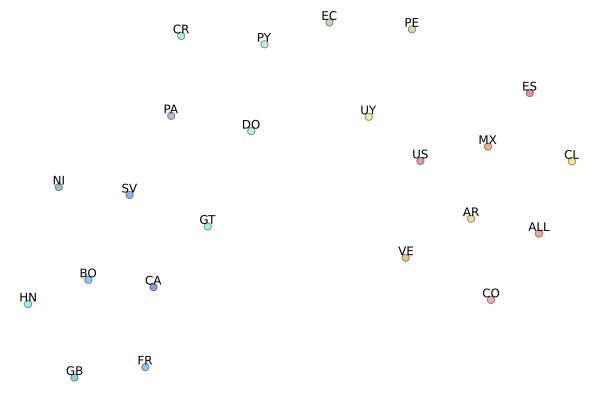

  0.000219 seconds (5 allocations: 2.391 KiB)
  0.000006 seconds (3 allocations: 2.047 KiB)


┌ Info: ======= k=10 =====
└ @ Main In[7]:9
*** computing graph
*** layout embedding SpectralLayout
*** fit ab / embedding
*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 5.1296e-5
- embedding init: 0.000334488
- embedding opt: 0.006964337

*** computing graph
*** layout embedding SpectralLayout
*** fit ab / embedding
*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 5.7782e-5
- embedding init: 0.000289679
- embedding opt: 0.006770895

┌ Info: (:r, :g, :b)
└ @ Main In[7]:33


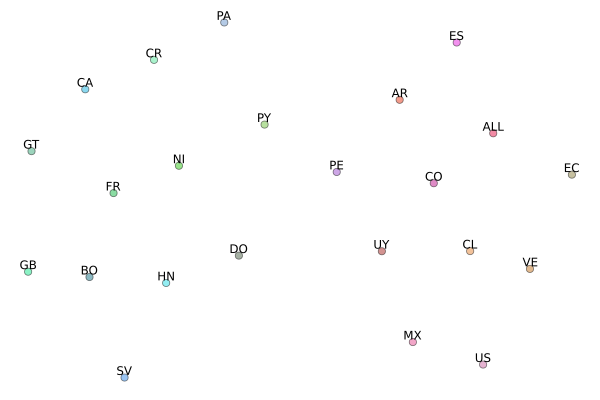

  0.000232 seconds (3 allocations: 2.359 KiB)


┌ Info: ======= k=12 =====
└ @ Main In[7]:9
*** computing graph
*** layout embedding SpectralLayout
*** fit ab / embedding
*** opt embedding


  0.000011 seconds (3 allocations: 2.359 KiB)


UMAP construction time cost report:
- fuzzy graph: 5.0631e-5
- embedding init: 0.000313908
- embedding opt: 0.024669245

*** computing graph
*** layout embedding SpectralLayout
*** fit ab / embedding
*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 7.1477e-5
- embedding init: 0.000283831
- embedding opt: 0.010017854

┌ Info: (:r, :g, :b)
└ @ Main In[7]:33


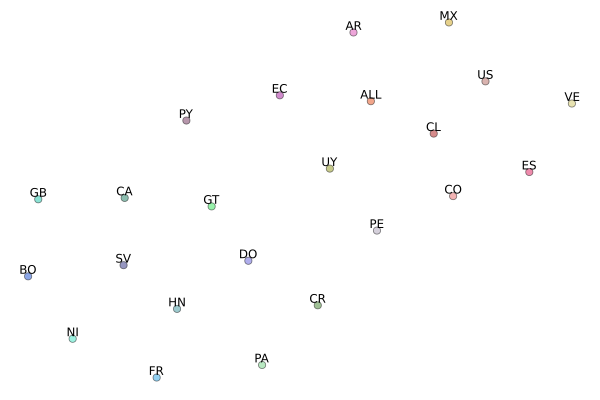

In [7]:
min_dist = 0.7
neg_sample_rate = 5
local_connectivity = 1
layout = SpectralLayout()
n_epochs = 300
tol = 1e-5

for k in 4:2:12
    @info "======= k=$k ====="
    U2 = fit(UMAP, PrecomputedAffinityMatrix(A); maxoutdim=2,
            layout, k, local_connectivity, neg_sample_rate, min_dist, n_epochs, tol)

    U3 = fit(UMAP, PrecomputedAffinityMatrix(A); maxoutdim=3,
            layout, k, local_connectivity, neg_sample_rate, min_dist, n_epochs, tol)

    X = predict(U2)
    C = creatergb!(predict(U3))
    #C .= C .+ 5

    #poslist = rand([:right, :left, :bottom, :top], length(cclist))
    poslist = rand([:bottom], length(VALID_CC))

    scatter(X[1, :], X[2, :], c=C, label="",
        series_annotations=[text(VALID_CC[i], poslist[i], 8) for i in eachindex(VALID_CC)],
        xticks=nothing, yticks=nothing, xaxis=false, yaxis=false,
        ms=4, ma=0.5, fa=0.5, la=0.5, alpha=0.5
    )
    #scatter!(X[1, :], X[2, :], c=C, label="",
    #    series_annotations=[text(cclist[i], poslist[i], 10, C[i]) for i in eachindex(cclist)], xticks=nothing, yticks=nothing, xaxis=false, yaxis=false,
    #    ms=5, ma=0.5, fa=0.5, la=0.5, alpha=0.5)
    savefig("../figs/fig-voc-semantic-umap-$k.pdf")
    savefig("../figs/fig-voc-semantic-umap-$k.png")
    @info fieldnames(typeof(C[1]))
    open(joinpath(edir, "colormap-common-voc-semantic-$k.csv"), "w") do f
        println(f, "country,R,G,B")
        for (i, (cc, c)) in enumerate(zip(VALID_CC, C))
            println(f, cc, ",", c.r, ",", c.g, ",", c.b)
        end
    end
    
    plot!(fmt=:png) |> display
end



In [8]:
#=D = Dict(zip(cclist, db))
@show [
evaluate(dist, D["MX"], D["MX"])
evaluate(dist, D["MX"], D["ALL"])
evaluate(dist, D["MX"], D["SV"])
evaluate(dist, D["ES"], D["GQ"])
]

@info D["MX"][:iglesia]
@info D["US"][:iglesia]
=#

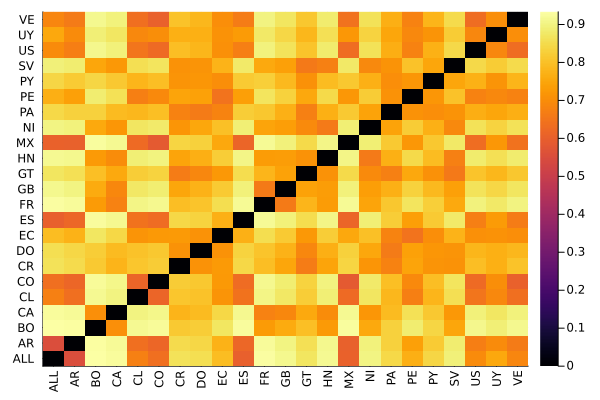

In [9]:
#heatmap(cclist, cclist, A, ticks = :all, xrot=90)
heatmap(VALID_CC, VALID_CC, A, ticks = :all, xrot=90)
savefig("../figs/fig-common-words-semantic-affinity-matrix.pdf")
savefig("../figs/fig-common-words-semantic-affinity-matrix.png")
plot!(fmt=:png)